In [104]:
import sys
sys.path.append("..")

# Reload modules in /src/ when changed
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (12, 2)
import seaborn as sns
sns.set(style="ticks", palette="tab10")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
from fxml.data.datamodules.multistep_regr_datamodule import MultiStepRegrDataModule
from fxml.models.t2v_transformer_regr.model import T2VTransformerRegressorModule
from fxml.data.normalize_data import denorm

import joblib
from pathlib import Path
from numpy.lib.stride_tricks import sliding_window_view
import torch

In [106]:
from hydra import compose, initialize
from omegaconf import OmegaConf

# global initialization
with initialize(version_base=None, config_path="../configs", job_name="test_app"):
    exp_cfg = compose(config_name="tune_t2v_xfmr")
    data_cfg = compose(config_name="preprocessing")
    print(OmegaConf.to_yaml(exp_cfg))
    print(OmegaConf.to_yaml(data_cfg))

data:
  train_path: data/processed/USDJPY-15m-20210101-20231231_FEATURES_NORM.pkl
  test_path: data/processed/USDJPY-15m-20240101-20241231_FEATURES_NORM.pkl
  time_features:
  - open
  - high
  - low
  - close
  features:
  - volume
  - close_log_fd_return
  - close_log_return
  - EMA_5
  - EMA_9
  - EMA_20
  - EMA_24
  - EMA_36
  - EMA_50
  - EMA_100
  - EMA_5_slope
  - EMA_9_slope
  - EMA_20_slope
  - EMA_24_slope
  - EMA_36_slope
  - EMA_50_slope
  - EMA_100_slope
  - ATRr_14
  - ATRr_60
  - ATRr_120
  - RSI_14
  target:
  - close
  lookback: 60
  lookforward: 5
model:
  name: t2v_transformer_regr
  kernel_size: 2
  d_model: 128
  nhead: 4
  n_layers: 2
  dim_feedforward: 512
  dropout: 0.2
  pool: cls
  lr: 0.0003
  use_positional_encoding: true
training:
  batch_size: 1024
  num_epochs: 100
  num_workers: 0
  val_split: 0.5
  shuffle: true

data:
  train_data_path: data/processed/USDJPY-15m-20210101-20231231_FEATURES.pkl
  test_data_path: data/processed/USDJPY-15m-20240101-2024123

In [107]:
root_dir = Path('..')
data = pd.read_pickle('../data/processed/USDJPY-15m-20240101-20241231_FEATURES.pkl') # original data

# Normalize features

In [108]:
from fxml.data.normalize_data import normalize
from fxml.data.datamodules.multistep_regr_datamodule import create_multistep_sequences

In [109]:
scaler_cfg = data_cfg.scaler
norm_df = data.copy()

In [110]:
norm_df = normalize(
    data=norm_df,
    data_name='USDJPY-15m-20210101-20231231_FEATURES',
    scaler_cfg=scaler_cfg,
    scaler_dir='../data/processed/scalers'
)

# Create Sequences

In [111]:
lookback = 60
lookforward = 5
idx = 20000

feat_cols = exp_cfg.data.time_features + exp_cfg.data.features 

In [112]:
_, target_windows = create_multistep_sequences(
    data,
    lookback,
    lookforward,
    feat_cols,
    target_col=['close'],
)

feature_windows, _ = create_multistep_sequences(
    norm_df,
    lookback,
    lookforward,
    feat_cols,
    target_col=['close'],
)

In [113]:
print(feature_windows.shape, target_windows.shape)

(23918, 60, 25) (23918, 5)


## Predict Sequences

In [114]:
X = torch.tensor(feature_windows[idx], dtype=torch.float32)

In [115]:
X = X.unsqueeze(0)
X.shape

torch.Size([1, 60, 25])

In [116]:
model = T2VTransformerRegressorModule.load_from_checkpoint('../lightning_logs/t2v_transformer_regr_USDJPY-15m-20210101-20231231_FEATURES_NORM/version_3/checkpoints/best_checkpoint.ckpt')

In [117]:
model = model.to('cpu')

In [118]:
with torch.no_grad():
    model.eval()
    pred = model(X).numpy().reshape(-1, 1)

pred.shape

(5, 1)

# De-Normalize Prediction

In [119]:
scaler = joblib.load('../data/processed/scalers/USDJPY-15m-20210101-20231231_FEATURES/close_std.pkl')

In [120]:
y_true = target_windows[idx]

In [121]:
y_pred = scaler.inverse_transform(pred).squeeze()
y_pred

array([142.64977, 142.75356, 142.6453 , 142.74011, 142.6802 ],
      dtype=float32)

In [122]:
print(y_true)

[152.69   151.9265 152.0385 152.0325 152.2555]


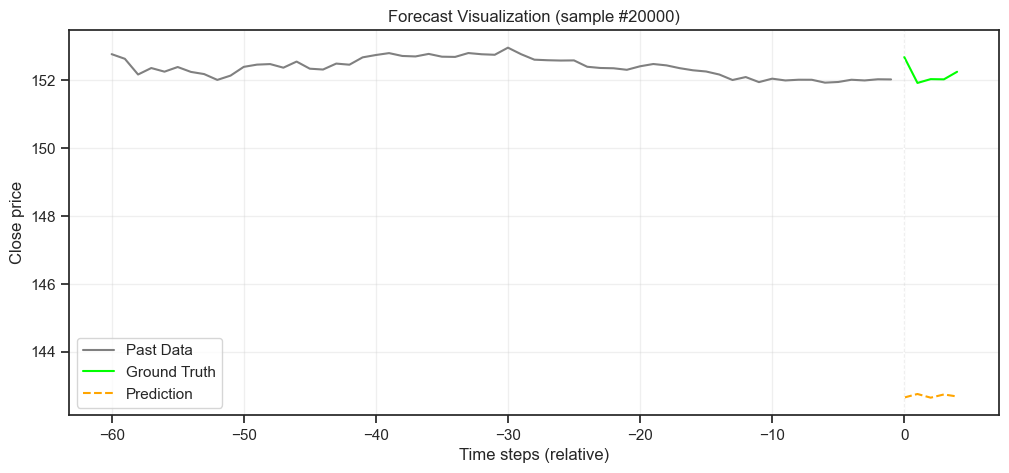

In [123]:
import matplotlib.pyplot as plt
import numpy as np



past = data['close'][idx - lookback : idx]                       # 模型預測（長度同 lookforward）

plt.figure(figsize=(12,5))
plt.plot(range(-lookback, 0), past, label="Past Data", color="gray")
plt.plot(range(0, lookforward), y_true, label="Ground Truth", color="lime")
plt.plot(range(0, lookforward), y_pred, label="Prediction", color="orange", linestyle="--")

plt.axvline(0, color="white", linestyle=":")
plt.title(f"Forecast Visualization (sample #{idx})")
plt.xlabel("Time steps (relative)")
plt.ylabel("Close price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
